In [285]:
%matplotlib notebook
from ipywidgets import *
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# This is the url the lead field is downloaded from:
#nyhead_url = 'https://www.parralab.org/nyhead/sa_nyhead.mat'
nyhead_file = "sa_nyhead.mat"

if not os.path.isfile(nyhead_file):
    from urllib.request import urlopen
    import ssl
    print("New York head-model file not found: %s" % nyhead_file)
    yn = input(f"Download as {nyhead_file} (710 MB)? [y/n]: ")
    if yn == 'y':
        print("Now downloading. This might take a while ...")
        nyhead_url = 'https://www.parralab.org/nyhead/sa_nyhead.mat'
        u = urlopen(nyhead_url,
                    context=ssl._create_unverified_context())
        localFile = open(nyhead_file, 'wb')
        localFile.write(u.read())
        localFile.close()
        print("Download done!")
    else:
        print("Exiting program ...")
        raise RuntimeError("Can not find %s" % nyhead_file)

with h5py.File(nyhead_file, 'r') as f:
    lead_field_normal = np.array(f["sa"]["cortex75K"]["V_fem_normal"])
    cortex = np.array(f["sa"]["cortex75K"]["vc"]) # Locations of every vertex in cortex
    normals = np.array(f["sa"]["cortex75K"]["normals"])
    elecs = np.array(f["sa"]["locs_3D"]) # 3D locations of electrodes
    elecs_2D = np.array(f["sa"]["locs_2D"]) # 2D projected locations of electrodes
    head_vc = np.array(f["sa"]["head"]["vc"])
    idxs_1K = np.array(f["sa"]["cortex1K"]["in_from_cortex75K"], dtype=int) - 1

x_ctx, y_ctx, z_ctx = cortex
x_h, y_h, z_h = head_vc[0, :], head_vc[1, :], head_vc[2, :]

p_z = 1e7  # nA µm

In [286]:

def plot_head_outline(ax, radius):
    circle_npts = 100
    head_x = radius * np.cos(np.linspace(0, 2 * np.pi, circle_npts))
    head_y = radius * np.sin(np.linspace(0, 2 * np.pi, circle_npts))
    patches = []
    right_ear = mpatches.FancyBboxPatch([radius + 0.05, -0.05], 
                                        -0.02, 0.15,
        boxstyle=mpatches.BoxStyle("Round", pad=0.05))
    patches.append(right_ear)

    left_ear = mpatches.FancyBboxPatch([-radius - 0.03, -0.05], 
                                       -0.02, 0.15,
        boxstyle=mpatches.BoxStyle("Round", pad=0.05))
    patches.append(left_ear)

    collection = PatchCollection(patches, facecolor='none', 
                                 edgecolor='k', alpha=1.0)
    ax.add_collection(collection)
    ax.plot(head_x, head_y, 'k', lw=1, zorder=1000)
    ax.plot([radius], lw=1)

    ax.plot([-0.1, 0, 0.1], 
            [radius, radius + 0.1, radius], 'k', lw=1)


<IPython.core.display.Javascript object>


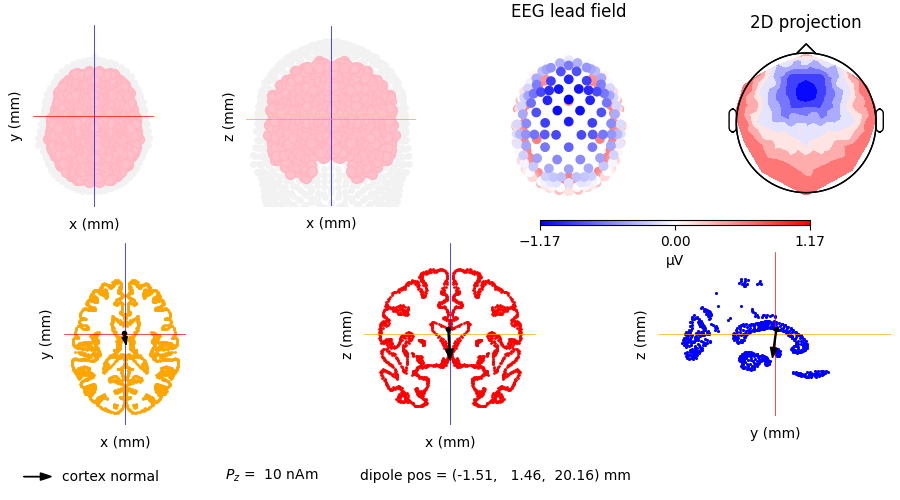

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [310]:

plane_clrs = ['b', 'r', 'orange']

def update(x, y, z):

    dipole_loc_ = np.array([x, y, z])
    vertex_idx = np.argmin(np.sqrt(np.sum((dipole_loc_[:, None] - cortex)**2, axis=0)))
    dipole_loc = cortex[:, vertex_idx]
    dipole_normal = normals[:, vertex_idx]
    
    eeg_lf = lead_field_normal[vertex_idx] * p_z * 1e-6  # µV
    vmax = np.max(np.abs(eeg_lf))
    vmin = -vmax
    clrs = np.array([plt.cm.bwr((eeg_lf_ - vmin) / (vmax - vmin)) for eeg_lf_ in eeg_lf])
    threshold = 2  # threshold in mm for including points in plot
    xy_plane_idxs = np.where(np.abs(cortex[2, :] - z) < threshold)[0]
    xz_plane_idxs = np.where(np.abs(cortex[1, :] - y) < threshold)[0]
    yz_plane_idxs = np.where(np.abs(cortex[0, :] - x) < threshold)[0]    
    
    l_xy_x_h.set_xdata(x)
    l_xy_y_h.set_ydata(y)
    l_xz_x_h.set_xdata(x)
    l_xz_z_h.set_ydata(z)
    l_xy_x_c.set_xdata(x)
    l_xy_y_c.set_ydata(y)
    l_xz_x_c.set_xdata(x)
    l_xz_z_c.set_ydata(z)    
    l_yz_y_c.set_xdata(y)
    l_yz_z_c.set_ydata(z)  

    l_dp_xy.set_xdata(dipole_loc[0])
    l_dp_xy.set_ydata(dipole_loc[1])
    l_dp_xz.set_xdata(dipole_loc[0])
    l_dp_xz.set_ydata(dipole_loc[2])
    l_dp_yz.set_xdata(dipole_loc[1])
    l_dp_yz.set_ydata(dipole_loc[2])
    
    
    [f.remove() for f in ax_xy.collections]
    [f.remove() for f in ax_xz.collections]
    [f.remove() for f in ax_yz.collections]
    [f.remove() for f in ax_eeg_3D.collections]
    [f.remove() for f in ax_eeg_2D.collections]
    
    [f.remove() for f in ax_xy.patches]
    [f.remove() for f in ax_xz.patches]
    [f.remove() for f in ax_yz.patches]
     
    plot_head_outline(ax_eeg_2D, 0.77)
    sc_eeg_3D = ax_eeg_3D.scatter(elecs[0][elecs_order], elecs[1][elecs_order], c=clrs[elecs_order])
    s_xy = ax_xy.scatter(cortex[0, xy_plane_idxs], cortex[1, xy_plane_idxs], s=1, c=plane_clrs[2])
    s_xz = ax_xz.scatter(cortex[0, xz_plane_idxs], cortex[2, xz_plane_idxs], s=1, c=plane_clrs[1])
    s_yz = ax_yz.scatter(cortex[1, yz_plane_idxs], cortex[2, yz_plane_idxs], s=1, c=plane_clrs[0])
    
    ar_xy = ax_xy.arrow(dipole_loc[0], dipole_loc[1], 
                    dipole_normal[0] * 10, dipole_normal[1] * 20, 
                    color='k', width=1, head_width=7, zorder=1e5, clip_on=False)
    ar_xz = ax_xz.arrow(dipole_loc[0], dipole_loc[2], 
                        dipole_normal[0] * 10, dipole_normal[2] * 20, 
                        color='k', width=1, head_width=7, zorder=1e5, clip_on=False)
    ar_yz = ax_yz.arrow(dipole_loc[1], dipole_loc[2], 
                        dipole_normal[1] * 10, dipole_normal[2] * 20, 
                        color='k', width=1, head_width=7, zorder=1e5, clip_on=False)
    
    eeg_2D_proj = ax_eeg_2D.tricontourf(elecs_2D[3], elecs_2D[4], 
                                        eeg_lf, cmap='bwr', vmax=vmax, vmin=vmin)
    m.set_clim(vmin, vmax)
    cbar.set_ticks([vmin, 0, vmax])
    loc_txt.set_text( 
               f'dipole pos = ({dipole_loc[0]: 0.2f},  {dipole_loc[1]: 0.2f}, {dipole_loc[2]: 0.2f}) mm')
    fig.canvas.draw_idle()

dipole_loc_insula = np.array([-44.38910377, 0.6447897, 0.20525938]) # x, y, z location in mm
dipole_loc_external = np.array([-64.76565194, -1.42899746, -0.93927646])
   
#dipole_loc = np.array([0, 0., 15.0]) # x, y, z location in mm
dipole_loc = dipole_loc_external # x, y, z location in mm
vertex_idx = np.argmin(np.sqrt(np.sum((dipole_loc[:, None] - cortex)**2, axis=0)))
dipole_loc = cortex[:, vertex_idx]
dipole_normal = normals[:, vertex_idx]

elecs_order = np.argsort(elecs[2])
    
eeg_lf = lead_field_normal[vertex_idx] * p_z * 1e-6 # µV
vmax = np.max(np.abs(eeg_lf))
vmin = -vmax
clrs = np.array([plt.cm.bwr((eeg_lf_ - vmin) / (vmax - vmin)) for eeg_lf_ in eeg_lf])

m = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax), cmap=plt.cm.bwr)

threshold = 2  # threshold in mm for including points in plot
xy_plane_idxs = np.where(np.abs(cortex[2, :] - dipole_loc[2]) < threshold)[0]
xz_plane_idxs = np.where(np.abs(cortex[1, :] - dipole_loc[1]) < threshold)[0]
yz_plane_idxs = np.where(np.abs(cortex[0, :] - dipole_loc[0]) < threshold)[0]

xlim = np.array([-80, 80])
ylim = np.array([-120, 120])
zlim = np.array([-70, 100])

fig = plt.figure(figsize=[9, 5])
fig.subplots_adjust(wspace=0.4, right=0.99, left=0.01, top=0.95, bottom=0.15)

ax_head_xy = fig.add_subplot(241, 
                          xticks=[], yticks=[], 
                          xlim=xlim*1.2, 
                          ylim=ylim*1.2, 
                          aspect=1, frameon=False,
                          xlabel="x (mm)", ylabel="y (mm)",
                          )
ax_head_xz = fig.add_subplot(242, 
                          xticks=[], yticks=[], 
                          xlim=xlim*1.2, 
                          ylim=zlim*1.2, 
                          aspect=1, frameon=False,
                          xlabel="x (mm)", ylabel="z (mm)",
                          )

ax_eeg_3D = fig.add_subplot(243, 
                          xticks=[], yticks=[], 
                          xlim=xlim*1.2, 
                          ylim=ylim*1.2, 
                          aspect=1, frameon=False,
                          title="EEG lead field"
                          )
ax_eeg_2D = fig.add_subplot(244, 
                          xticks=[], yticks=[], 
                          aspect=1, frameon=False,
                          title="2D projection"
                          )

plot_head_outline(ax_eeg_2D, 0.77)
ax_xy = fig.add_subplot(234, aspect=1, xlim=xlim, ylim=ylim, xticks=[], yticks=[],
                        xlabel="x (mm)", ylabel="y (mm)", frameon=False)
ax_xz = fig.add_subplot(235, aspect=1, xlim=xlim, ylim=zlim, xticks=[], yticks=[],
                        xlabel="x (mm)", ylabel="z (mm)", frameon=False)
ax_yz = fig.add_subplot(236, aspect=1, xlim=ylim, ylim=zlim, xticks=[], yticks=[],
                        xlabel="y (mm)", ylabel="z (mm)", frameon=False)

cax = fig.add_axes([0.6, 0.55, 0.3, 0.01])

l_xy_x_h = ax_head_xy.axvline(dipole_loc[0], c=plane_clrs[0], lw=0.5)
l_xy_y_h = ax_head_xy.axhline(dipole_loc[1], c=plane_clrs[1], lw=0.5)

l_xz_x_h = ax_head_xz.axvline(dipole_loc[0], c=plane_clrs[0], lw=0.5)
l_xz_z_h = ax_head_xz.axhline(dipole_loc[2], c=plane_clrs[2], lw=0.5)

l_xy_x_c = ax_xy.axvline(dipole_loc[0], c=plane_clrs[0], lw=0.5)
l_xy_y_c = ax_xy.axhline(dipole_loc[1], c=plane_clrs[1], lw=0.5)

l_xz_x_c = ax_xz.axvline(dipole_loc[0], c=plane_clrs[0], lw=0.5)
l_xz_z_c = ax_xz.axhline(dipole_loc[2], c=plane_clrs[2], lw=0.5)

l_yz_y_c = ax_yz.axvline(dipole_loc[1], c=plane_clrs[1], lw=0.5)
l_yz_z_c = ax_yz.axhline(dipole_loc[2], c=plane_clrs[2], lw=0.5)

l_dp_xy, = ax_xy.plot(dipole_loc[0], dipole_loc[1], 'o', c='k', ms=3)
l_dp_xz, = ax_xz.plot(dipole_loc[0], dipole_loc[2], 'o', c='k', ms=3)
l_dp_yz, = ax_yz.plot(dipole_loc[1], dipole_loc[2], 'o', c='k', ms=3)

ax_head_xy.scatter(head_vc[0], head_vc[1], c='0.95', s=15, clip_on=False)
ax_head_xy.scatter(cortex[0, idxs_1K ], cortex[1, idxs_1K], color='pink', s=50, ec='lightpink')

ax_head_xz.scatter(head_vc[0], head_vc[2], c='0.95', s=15,)
ax_head_xz.scatter(cortex[0, idxs_1K], cortex[2, idxs_1K], color="pink", ec='lightpink', clip_on=False, s=50)

s_xy = ax_xy.scatter(cortex[0, xy_plane_idxs], cortex[1, xy_plane_idxs], s=1, c=plane_clrs[2])
s_xz = ax_xz.scatter(cortex[0, xz_plane_idxs], cortex[2, xz_plane_idxs], s=1, c=plane_clrs[1])
s_yz = ax_yz.scatter(cortex[1, yz_plane_idxs], cortex[2, yz_plane_idxs], s=1, c=plane_clrs[0])

ar_xy = ax_xy.arrow(dipole_loc[0], dipole_loc[1], 
                    dipole_normal[0] * 10, dipole_normal[1] * 20, 
                    color='k', width=1, head_width=7, zorder=1e5, clip_on=False)
ar_xz = ax_xz.arrow(dipole_loc[0], dipole_loc[2], 
                    dipole_normal[0] * 10, dipole_normal[2] * 20, 
                    color='k', width=1, head_width=7, zorder=1e5, clip_on=False)
ar_yz = ax_yz.arrow(dipole_loc[1], dipole_loc[2], 
                    dipole_normal[1] * 10, dipole_normal[2] * 20, 
                    color='k', width=1, head_width=7, zorder=1e5, clip_on=False)

sc_eeg_3D = ax_eeg_3D.scatter(elecs[0][elecs_order], elecs[1][elecs_order], c=clrs[elecs_order])#cmap='bwr', vmax=vmax, vmin=-vmax)
eeg_2D_proj = ax_eeg_2D.tricontourf(elecs_2D[3], elecs_2D[4], 
                                    eeg_lf, cmap='bwr', vmax=vmax, vmin=vmin)

cbar = plt.colorbar(m, cax=cax, orientation="horizontal", label="µV")
cbar.set_ticks([vmin, 0, vmax])

# Weird hack just to display arrow in legend
from matplotlib.legend_handler import HandlerPatch
class HandlerArrow(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
fig.legend([ar_xz], ["cortex normal"], 
           handler_map={mpatches.FancyArrow : HandlerArrow()},
          frameon=False, loc=(0.02, 0.02))

fig.text(0.25, 0.04, f'$P_z$ = {p_z * 1e-6: 0.0f} nAm')
loc_txt = fig.text(0.4, 0.04, 
               f'dipole pos = ({dipole_loc[0]: 0.2f},  {dipole_loc[1]: 0.2f}, {dipole_loc[2]: 0.2f}) mm')

fig.savefig("EEG_example.png", dpi=200)
interact(update, x = (xlim[0], xlim[1], 0.1), y = (ylim[0], ylim[1], 0.1), z = (zlim[0], zlim[1], 0.1));


[-44.38910377   0.6447897    0.20525938] [-0.98879538 -0.14244142 -0.04465572]
[-64.76565194  -1.42899746  -0.93927646] [-0.94147685  0.32891411  0.073735  ]
0.09697539535318495
0.17138808152316123


<IPython.core.display.Javascript object>


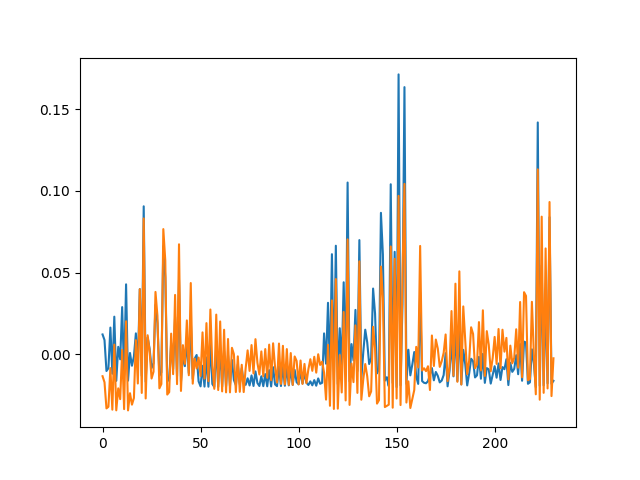

In [311]:

vertex_idx_insula = np.argmin(np.sqrt(np.sum((dipole_loc_insula[:, None] - cortex)**2, axis=0)))
dipole_loc_insula = cortex[:, vertex_idx_insula]

vertex_idx_external = np.argmin(np.sqrt(np.sum((dipole_loc_external[:, None] - cortex)**2, axis=0)))
dipole_loc_external = cortex[:, vertex_idx_external]

closest_elec_idx_insula = np.argmin(np.sqrt(np.sum((cortex[:, vertex_idx_insula, None] - 
                       elecs[:3, :])**2, axis=0)))
closest_elec_idx_external = np.argmin(np.sqrt(np.sum((cortex[:, vertex_idx_external, None] - 
                       elecs[:3, :])**2, axis=0)))


print(dipole_loc_insula, normals[:, vertex_idx_insula])
print(dipole_loc_external, normals[:, vertex_idx_external])

print(lead_field_normal[vertex_idx_insula][closest_elec_idx_insula])
print(lead_field_normal[vertex_idx_external][closest_elec_idx_external])

plt.close("all")

plt.plot(lead_field_normal[vertex_idx_external])
plt.plot(lead_field_normal[vertex_idx_insula])
plt.savefig("frac.png")
